In [1]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import time

In [2]:
# The load_path function loads the .jpg image and converts it to a numpy array. 
# It also extracts the image label from path and places it into file_array
import numpy as np
import os
from PIL import Image
import time
import glob
def load_data(paths):
    
    X = []
    file_array = []
    label_array = []
  
    # Images are resized because they range from 720-924 and 1192-1280 Making it difficult to use in models
    # and neural networks
    # Most 'common' original image size
    # The 'im.resize' switches these dimensions. That is why they are backwards here.
    size = 1280, 720
    
    print('..loading images')
    start = time.time()
    
    # if loading 'training set' also extract label from file
        
    for path in glob.glob(paths):

        try:
            # load image and convert to np array
            im = Image.open(path)
            im = im.resize((size[0], size[1]))
            im = np.asarray(im)
            X.append(im)

            # extract file name EX: img_00003.jpg
            base = os.path.basename(path)
            file_array.append(base)

            if 'train' in paths:
                # extract fish label (ALB, BET, DOL, LAG, NoF, OTEHR, SHARK, YFT)
                directory = os.path.split(path)[0]
                label_array.append(os.path.split(directory)[1])

        except IOError:
            print( "cannot load or resize image for %s" % path)


    print('time elapsed: ' + str(time.time() - start))

    if 'train' in paths:
        return X, file_array, label_array

    else:
        return X, file_array


In [3]:
# extracts list of 320x320 sub-images from image X
# returns windows and location of image center
def create_windows_from_image(X, window_height, window_width, window_vertical_slide, window_horizontal_slide):

    window_horizontal_idx = 0
    window_vertical_idx = 0
    window_array = []
    horizontal_num_windows = 0
    vertical_num_windows = 0
    window_center = []
    
    #slide horizontal then vertical
    while (window_vertical_idx+window_height) <= X.shape[1]:


        while (window_horizontal_idx+window_width) <= X.shape[2]:
            X_temp = X[0,window_vertical_idx:window_vertical_idx+window_height,
                             window_horizontal_idx:window_horizontal_idx+window_width,:]
            window_array.append(X_temp)
            
            #find window center wrt Image top left corner
            ver_center = window_height/2 +window_vertical_slide*vertical_num_windows
            hor_center = window_width/2 + window_horizontal_slide*horizontal_num_windows
            temp_center = [ver_center, hor_center]
            window_center.append(temp_center)
            
            window_horizontal_idx += window_horizontal_slide
            horizontal_num_windows += 1
            
            
            
        window_horizontal_idx = 0
        #print('horizontal_num_windows: ' + str(horizontal_num_windows))
        horizontal_num_windows = 0
        window_vertical_idx += window_vertical_slide
        vertical_num_windows += 1
    
    
    #print('vertical_num_windows: ' + str(vertical_num_windows))
    return window_array, window_center

In [4]:
# reshape X for cnn (samples, channels, rows, columns)
# where X is originally (samples, rows, columns, channels)
def reshape_for_cnn(X):
    
    X_cnn = np.zeros([X.shape[0], X.shape[3], X.shape[1], X.shape[2]])
    for samples in xrange(X.shape[0]):
        for channels in xrange(X.shape[3]):
            X_cnn[samples,channels,:,:] = X[samples,:,:,channels]
            
    return X_cnn

In [5]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

def VGG_19(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [6]:
from random import shuffle

def shuffle_X_and_Y(X, Y):
    # Given list X and list Y
    
    X_shuf = []
    Y_shuf = []
    
    index_shuf = np.arange(len(X))
    
    #shuffle it twice!
    shuffle(index_shuf)
    shuffle(index_shuf)
    
    for i in xrange(len(X)):
        X_shuf.append(X[index_shuf[i]])
        Y_shuf.append(Y[index_shuf[i]])
        
    return(X_shuf, Y_shuf)

In [7]:
# extend image 'naturally
# fill image with zeros or 'naturally' to retain aspect ratio but obtain image shape needed for NN
def fill_image(X_windows_reduced):
    
    X_windows_filled = []

    
    if X_windows_reduced[0].shape[0] < X_windows_reduced[0].shape[1]:
        ratio = X_windows_reduced[0].shape[0]/float(X_windows_reduced[0].shape[1])
        offset = int((224/2.0) - 224*ratio/2.0)
        
        for sample in xrange(len(X_windows_reduced)):
            blank = np.zeros([224, 224, 3])
            blank[offset:offset+X_windows_reduced[0].shape[0],:,:] = X_windows_reduced[sample]
            X_windows_filled.append(blank)
            
        
    else:   
        ratio = X_windows_reduced[0].shape[1]/float(X_windows_reduced[0].shape[0])
        offset = int((224/2.0) - 224*ratio/2.0)
        
        for sample in xrange(len(X_windows_reduced)):
            blank = np.zeros([224, 224, 3])
            blank[:,offset:offset+X_windows_reduced[0].shape[1],:] = X_windows_reduced[sample]
            X_windows_filled.append(blank)
            
    return X_windows_filled

In [8]:
model = VGG_19('F:/Kaggle/ImageNet/VGG/vgg19_weights.h5')

IOError: Unable to open file (Unable to open file: name = 'f:/kaggle/imagenet/vgg/vgg19_weights.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [10]:
X, file_array, label_array = load_data('F:/Kaggle/The Nature Conservancy/train/train/*/*')

..loading images
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_01127.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_01738.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_02263.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_03698.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_03851.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_04100.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_04205.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_04340.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_04878.jpg
cannot load or resize image for F:/Kaggle/The Nature Conservancy/train/train\ALB\img_05104.jpg
cannot load or resize image for F

In [256]:
def make_image_square(X_windows, WINDOW_HEIGHT, WINDOW_WIDTH):
    
    # if window is not square, make it
    if WINDOW_HEIGHT != WINDOW_WIDTH:
        X_windows_resize = []

        if WINDOW_HEIGHT > WINDOW_WIDTH:
            ratio = WINDOW_WIDTH/float(WINDOW_HEIGHT)
            dim = int(224*ratio)
            for window in xrange(len(X_windows)):
                X_windows_resize.append(cv2.resize(X_windows[window], (dim,224)).astype(np.uint8))

            X_windows_filled = fill_image(X_windows_resize)  


        else:
            ratio = WINDOW_HEIGHT/float(WINDOW_WIDTH)
            dim = int(224*ratio)
            for window in xrange(len(X_windows)):
                X_windows_resize.append(cv2.resize(X_windows[window], (224,dim)).astype(np.uint8))

            X_windows_filled = fill_image(X_windows_resize)  

        X_for_cnn = np.asarray(X_windows_filled)


    # if window is square, make it 224x224
    else:    
        X_windows_resize = []
        for i in xrange(len(X_windows)):
            X_windows_resize.append(cv2.resize(X_windows[i], (224,224)).astype(np.uint8))

        X_for_cnn = np.asarray(X_windows_resize)

            
    return X_for_cnn

In [1052]:
# shuffle X and labels for good sample (200 samples)
NUM_SAMPLES = 200
X_shuff, Y_shuff = shuffle_X_and_Y(X, label_array)
X_shuff = X_shuff[:NUM_SAMPLES]
Y_shuff = Y_shuff[:NUM_SAMPLES]

In [1089]:
# shuffle X and labels for good sample (200 samples)
NUM_SAMPLES = 20

#X_shuff = X_shuff[:NUM_SAMPLES]
#Y_shuff = Y_shuff[:NUM_SAMPLES]
X_shuff = X[:NUM_SAMPLES]

X_train = np.asarray(X_shuff)

In [1172]:
# predictions of fish using VGG19
from __future__ import print_function
# list containing all predicted centers
pred_centers_array = []
window_pred_array = []
prediction_array = []

for sample in xrange(X_train.shape[0]):
    
    
    pred_centers= []
    window_sample_pred = []
    sample_prediction = []
    WINDOW_HEIGHT =           [235, 230, 225]
    WINDOW_WIDTH =            [250, 250, 250]
    WINDOW_VERTICAL_SLIDE =   [60, 60, 60]
    WINDOW_HORIZONTAL_SLIDE = [70, 70, 70]
    
    #iterate through aspect ratios
    for i in xrange(len(WINDOW_HEIGHT)):
        
        pred_array = []
        start = time.time()

        X_windows, window_centers = create_windows_from_image(X_train[sample:sample+1,:,:,:],
                                              window_height = WINDOW_HEIGHT[i],
                                              window_width = WINDOW_WIDTH[i],
                                              window_vertical_slide = WINDOW_VERTICAL_SLIDE[i],
                                              window_horizontal_slide = WINDOW_HORIZONTAL_SLIDE[i])
        
        X_for_cnn = make_image_square(X_windows, WINDOW_HEIGHT[i], WINDOW_WIDTH[i])
        

        #X_cnn = np.asarray(X_windows_filled)#resize2)
        X_cnn = reshape_for_cnn(X_for_cnn)

        predictions = model.predict(X_cnn)

        fish_predictions_norm = predictions[:,4]/np.max(predictions[:,4])
        pred_array.append(np.where(fish_predictions_norm>0.7)[0])

        centers_temp = []
        windows_temp = []
        predictions_temp = []
        for j in xrange(len(pred_array)):
            for k in xrange(len(pred_array[j])):
                centers_temp.append(window_centers[pred_array[j][k]])
                windows_temp.append(X_windows[pred_array[j][k]])
                predictions_temp.append(predictions[pred_array[j][k],4])
        
        pred_centers.append(centers_temp)
        window_sample_pred.append(windows_temp)
        sample_prediction.append(predictions_temp)
        
        print('sample: %d' %sample + ' time elapsed: %f' %(time.time() - start))
        print( end='\r')
        
    pred_centers_array.append(pred_centers)
    window_pred_array.append(window_sample_pred)
    prediction_array.append(sample_prediction)
    
print('')
print('done')
    

sample: 0 time elapsed: 5.362000
sample: 0 time elapsed: 5.400000
sample: 0 time elapsed: 5.278000
sample: 1 time elapsed: 5.345000
sample: 1 time elapsed: 5.250000
sample: 1 time elapsed: 5.316000
sample: 2 time elapsed: 5.263000
sample: 2 time elapsed: 5.315000
sample: 2 time elapsed: 5.353000
sample: 3 time elapsed: 5.295000
sample: 3 time elapsed: 5.292000
sample: 3 time elapsed: 5.335000
sample: 4 time elapsed: 5.322000
sample: 4 time elapsed: 5.291000
sample: 4 time elapsed: 5.353000
sample: 5 time elapsed: 5.278000
sample: 5 time elapsed: 5.288000
sample: 5 time elapsed: 5.268000
sample: 6 time elapsed: 5.305000
sample: 6 time elapsed: 5.293000
sample: 6 time elapsed: 5.283000
sample: 7 time elapsed: 5.323000
sample: 7 time elapsed: 5.318000
sample: 7 time elapsed: 5.251000
sample: 8 time elapsed: 5.263000
sample: 8 time elapsed: 5.264000
sample: 8 time elapsed: 5.351000
sample: 9 time elapsed: 5.319000
sample: 9 time elapsed: 5.298000
sample: 9 time elapsed: 5.287000
sample: 10

In [1173]:
prediction_array[SAMPLE][0]

[0.16148171, 0.21140632, 0.19778273, 0.15536432]

In [1174]:
Y_shuff

['ALB',
 'SHARK',
 'BET',
 'NoF',
 'ALB',
 'OTHER',
 'ALB',
 'ALB',
 'NoF',
 'YFT',
 'OTHER',
 'ALB',
 'YFT',
 'YFT',
 'ALB',
 'OTHER',
 'ALB',
 'ALB',
 'DOL',
 'NoF']

In [1175]:
SAMPLE = 12
#print(pred_array[SAMPLE])
print(Y_shuff[SAMPLE])

YFT


# Images before applying 'ocean' removal

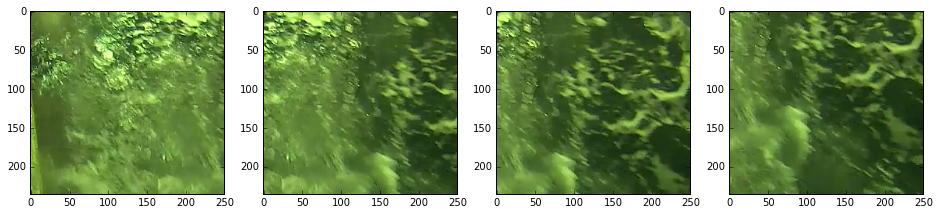

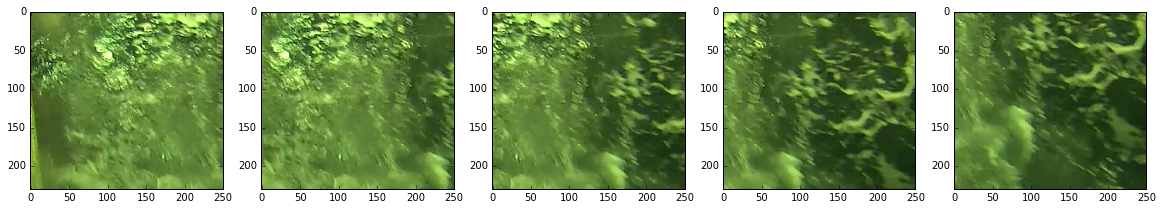

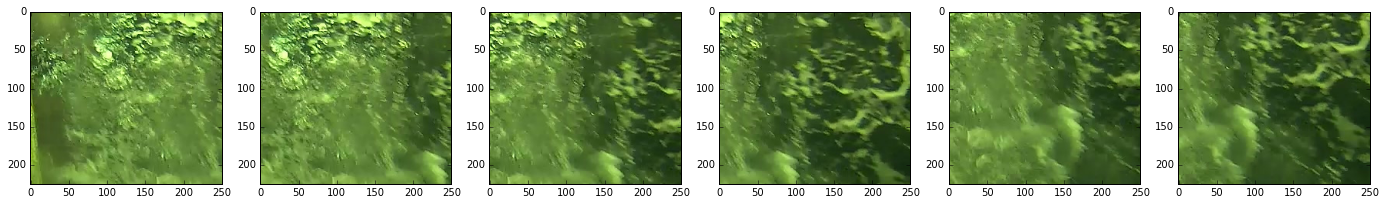

In [1176]:
samples = len(window_pred_array[SAMPLE])

for sample in xrange(samples):
    img = 1
    num_img = len(window_pred_array[SAMPLE][sample])
    fig = plt.figure(figsize=(4*num_img, 4*num_img))
    
    for i in xrange(num_img):
        plt.subplot(1, num_img,img)
        plt.imshow(window_pred_array[SAMPLE][sample][i])
        img += 1
    
    plt.show()

# Images after applying 'ocean' removal

In [1177]:
len(window_pred_array)

20

In [1178]:
import random
SEED = 448
random.seed(SEED)



In [1179]:
# separate window into 4x4 grid. randomize grid. comine back into 1 window
# window, in this case, must be 224x224
from random import shuffle
import random
SEED = 7
random.seed(SEED)
new_imgs = []
new_centers = []
new_preds = []

for sample in xrange(len(window_pred_array)):
    sample_imgs = []
    sample_centers = []
    sample_preds = []
    print(sample)
    
    for ar in xrange(len(window_pred_array[sample])):
        for image in xrange(len(window_pred_array[sample][ar])):
            
            
            img = window_pred_array[sample][ar][image]
            img_height = img.shape[0]
            img_width = img.shape[1]
            img_square = cv2.resize(img, (224,224)).astype(np.uint8)
            img_square = np.reshape(img_square, [1, 224, 224, 3])
            #X_cnn = reshape_for_cnn(img_square)
        
            img_windows, window_centers = create_windows_from_image(img_square,
                                                  window_height = 112,
                                                  window_width = 112,
                                                  window_vertical_slide = 112,
                                                  window_horizontal_slide = 112)

            random.shuffle(img_windows)
            random.shuffle(img_windows)
            
            rand_img_windows = np.asarray(img_windows)

            rand_img = np.reshape(rand_img_windows, [224, 224, 3])
            rand_img =  cv2.resize(rand_img, (img_width,img_height)).astype(np.uint8)
            window_list = []
            window_list.append(rand_img)
            
            
            X_for_cnn = make_image_square(window_list, img_height, img_width)
            X_cnn = reshape_for_cnn(X_for_cnn)
            
            new_predictions = model.predict(X_cnn)
            old_prediction = prediction_array[sample][ar][image]
            new_prediction = new_predictions[0,4]
            
            ratio = old_prediction/float(new_prediction)
    
            
            if ratio > 10:
                sample_imgs.append(img)
                sample_centers.append(pred_centers_array[sample][ar][image])
                sample_preds.append(prediction_array[sample][ar][image])
                

    new_imgs.append(sample_imgs)
    new_centers.append(sample_centers)
    new_preds.append(sample_preds)
    
print('')
print('done')
    
# remove image if old_prediction/new_prediction < 100 (less than order of magnitide 2)
# and img_loc |z(x,y)|> 1

# or old_prediction/new_prediction < 2
# or old_prediction < new_prediction

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19

done


In [1180]:
len(new_imgs[3])

3

0


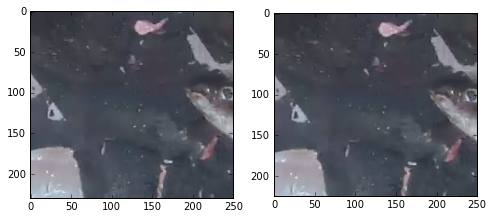

1


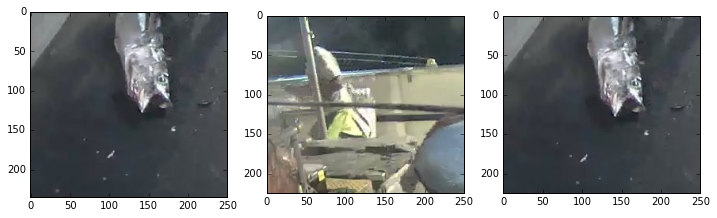

2


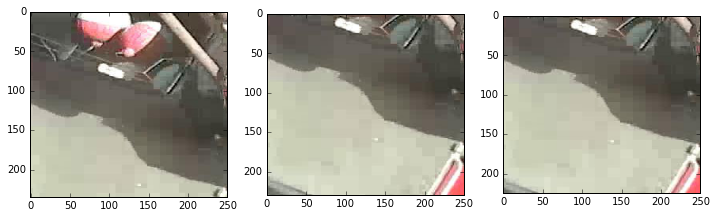

3


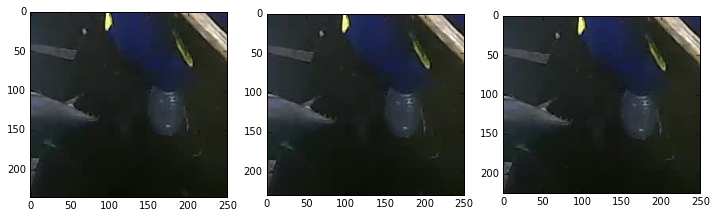

4


5


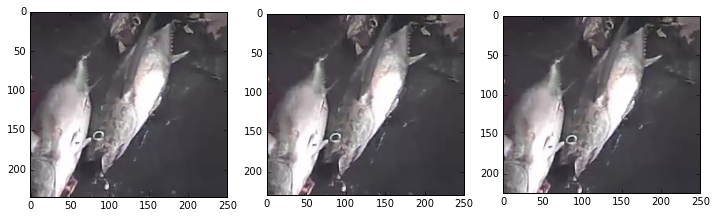

6


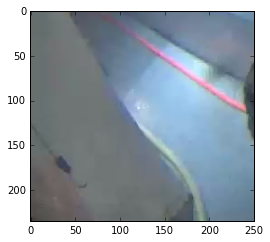

7


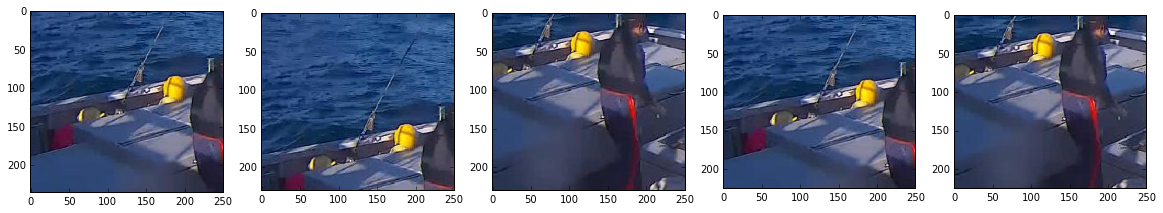

8


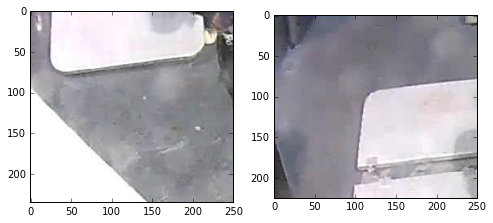

9


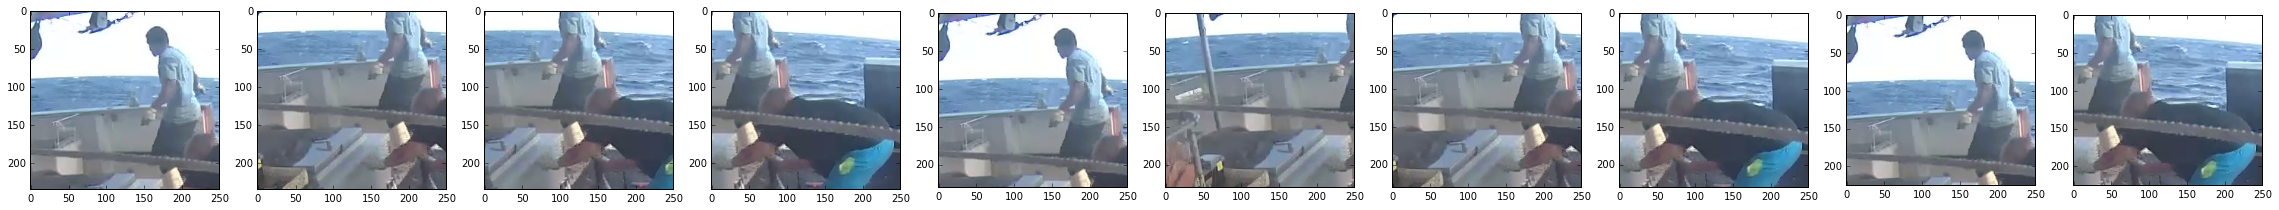

10


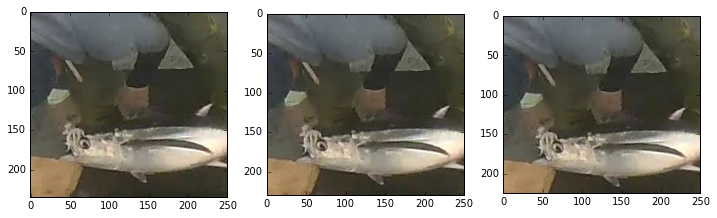

11


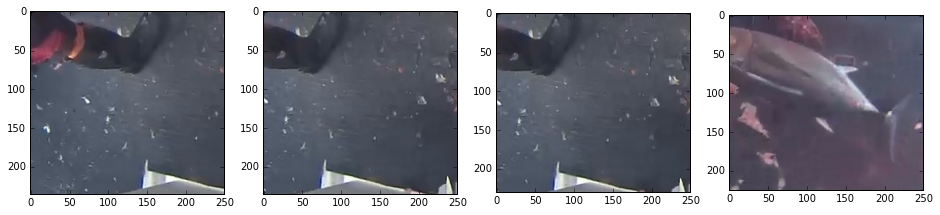

12


13


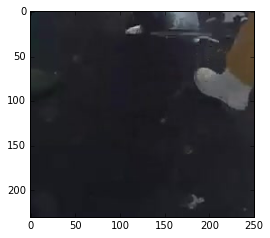

14


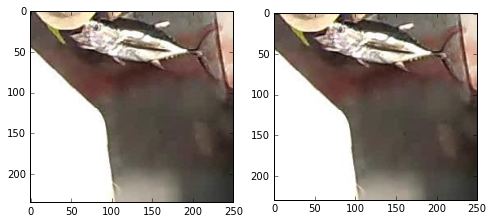

15


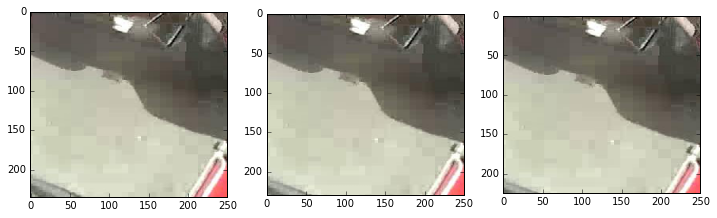

16


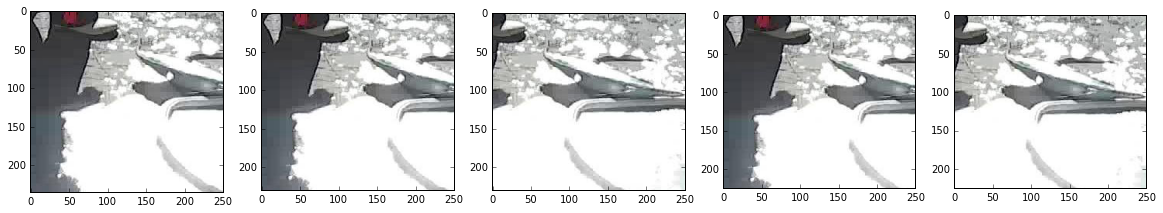

17


18


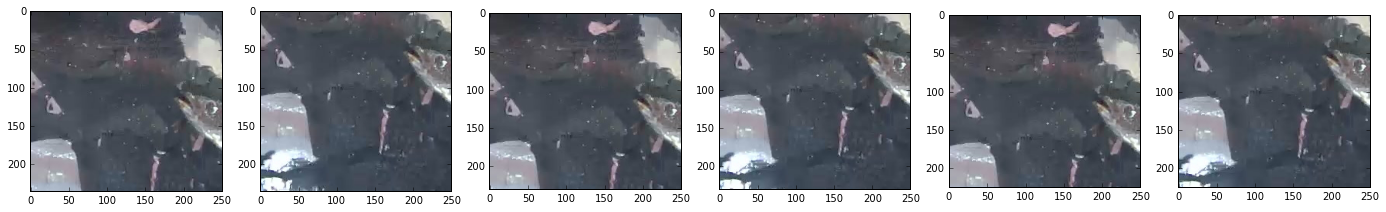

19


In [1181]:
samples = len(new_imgs)

for sample in xrange(samples):
    img = 1
    num_img = len(new_imgs[sample])
    fig = plt.figure(figsize=(4*num_img, 4*num_img))
    print(sample)
    for image in xrange(num_img):
        plt.subplot(1, num_img, image+1)
        plt.imshow(new_imgs[sample][image])
        img += 1
    
    plt.show()

# image proximities

In [1071]:
SAMPLE

2

In [1064]:
# reshape prediction centers into nx2 array
loc_array = []
for ar in xrange(len(pred_centers_array[SAMPLE])):
    for img in xrange(len(pred_centers_array[SAMPLE][ar])):
        loc_array.append(pred_centers_array[SAMPLE][ar][img])
        print(pred_centers_array[SAMPLE][ar][img])
        
loc_array = np.asarray(loc_array)

[365, 485]
[320, 870]
[320, 980]
[250, 900]
[300, 900]
[300, 650]


In [1065]:
from scipy import stats

In [1066]:
z = stats.mstats.zscore(loc_array, axis=0)

In [1067]:
z

array([[ 1.63220555, -1.80931547],
       [ 0.3166966 ,  0.41976119],
       [ 0.3166966 ,  1.05664023],
       [-1.72965066,  0.59345547],
       [-0.26797405,  0.59345547],
       [-0.26797405, -0.8539969 ]])

In [1068]:
# convert to polar
r = np.sqrt(np.sum(loc_array*loc_array, axis=1))
tan = -1*loc_array[:,0]/loc_array[:,1].astype(np.float)
theta = (360./(2*np.pi))*np.arctan(tan)

r_t = np.zeros([len(theta),2])
r_t[:,0] = r
r_t[:,1] = theta

In [1069]:
z_polar = stats.mstats.zscore(r_t, axis=0)
z_polar

array([[-1.71083883, -2.05526039],
       [ 0.4479031 ,  0.29983587],
       [ 1.14910908,  0.59627951],
       [ 0.49575358,  0.9557008 ],
       [ 0.59429317,  0.54691596],
       [-0.97622008, -0.34347175]])

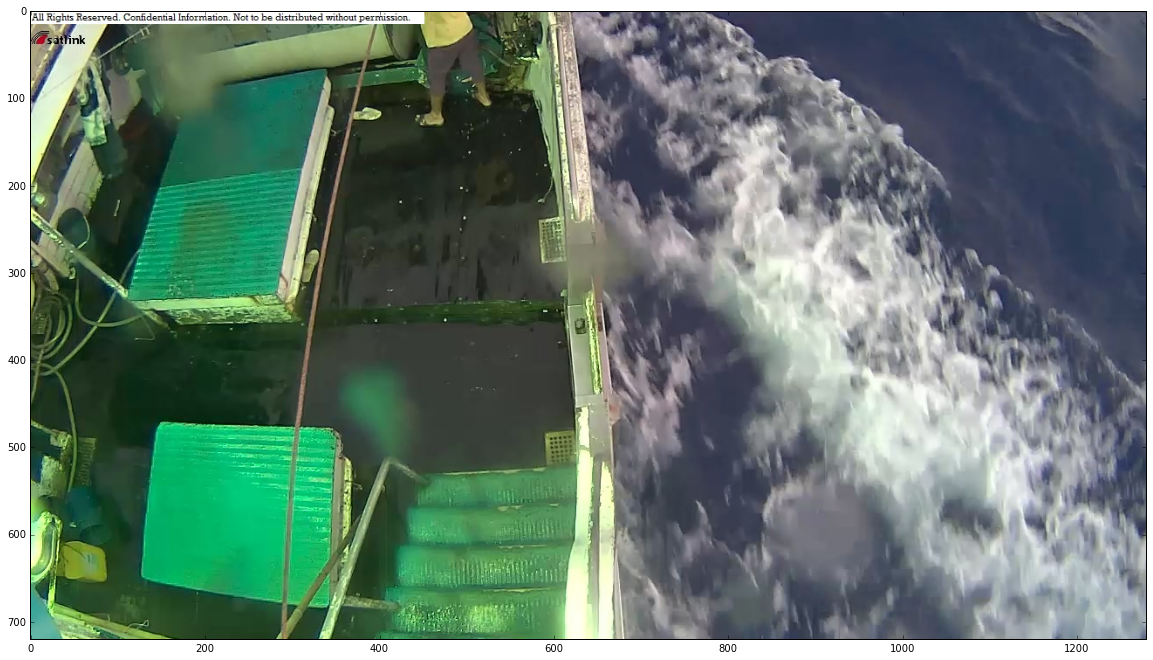

In [1082]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(X_train[SAMPLE,:,:,:])


In [81]:
X_cnn = np.asarray(X_temp_windows)
X_cnn = reshape_for_cnn(X_cnn)

start = time.time()
predictions = model.predict(X_cnn)
print('time elapsed: %f' %(time.time() - start))

predictions[54,4]

time elapsed: 2.102000


0.0053325174

In [71]:
X_temp_windows[42].shape

(224L, 224L, 3L)